In [33]:
import requests  
import pandas as pd  
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt 
import seaborn as sns 
from dotenv import load_dotenv
import os

load_dotenv()

sns.set_style("whitegrid")

Now lets get info from the The Movie DB API

In [34]:
API_KEY = os.getenv('API_KEY')
API_BASE_URL = 'https://api.themoviedb.org/3'


movie_data_list = []
for page in range(1, 11):
    url = f"{API_BASE_URL}/discover/movie?api_key={API_KEY}&primary_release_year=2025&sort_by=popularity.desc&page={page}"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        movie_data_list.extend(data['results'])
    else:
        print(f"Error fetching page {page}: {response.status_code}")
        break

print(movie_data_list)

[{'adult': False, 'backdrop_path': '/7QirCB1o80NEFpQGlQRZerZbQEp.jpg', 'genre_ids': [10749, 18], 'id': 1156594, 'original_language': 'es', 'original_title': 'Culpa nuestra', 'overview': "Jenna and Lion's wedding brings about the long-awaited reunion between Noah and Nick after their breakup. Nick's inability to forgive Noah stands as an insurmountable barrier. He, heir to his grandfather's businesses, and she, starting her professional life, resist fueling a flame that's still alive. But now that their paths have crossed again, will love be stronger than resentment?", 'popularity': 1096.6654, 'poster_path': '/yzqHt4m1SeY9FbPrfZ0C2Hi9x1s.jpg', 'release_date': '2025-10-15', 'title': 'Our Fault', 'video': False, 'vote_average': 7.872, 'vote_count': 292}, {'adult': False, 'backdrop_path': '/2yo2k8CmgZxfBQYAZ8TnHIYzEme.jpg', 'genre_ids': [28, 80, 53], 'id': 1072699, 'original_language': 'pl', 'original_title': 'Druga Furioza', 'overview': 'In the wake of murder, new Furioza leader Golden cl

In [35]:
tmdb_df = pd.DataFrame(movie_data_list)
tmdb_df = tmdb_df[['title', 'vote_average', 'release_date', 'popularity']]

print(f"Successfully fetched data for {len(tmdb_df)} movies from TMDb.")
tmdb_df.head()

Successfully fetched data for 200 movies from TMDb.


,title,vote_average,release_date,popularity
0,Our Fault,7.872,2025-10-15,1096.6654
1,Inside Furioza,6.833,2025-10-14,407.1937
2,Captain Hook - The Cursed Tides,6.000,2025-07-11,370.1091
3,War of the Worlds,4.400,2025-07-29,327.8760
4,The Conjuring: Last Rites,6.980,2025-09-03,284.0186


Clean data

In [36]:
print("Missing values per column:")
print(tmdb_df.isnull().sum())

tmdb_df.dropna(inplace=True)

tmdb_df['vote_average'] = pd.to_numeric(tmdb_df['vote_average'])
tmdb_df['popularity'] = pd.to_numeric(tmdb_df['popularity'])

Missing values per column:
title           0
vote_average    0
release_date    0
popularity      0
dtype: int64


Analysis of API

In [37]:
correlation = tmdb_df['popularity'].corr(tmdb_df['vote_average'])
print(f"\nCorrelation between Popularity and Vote Average: {correlation:.2f}")


Correlation between Popularity and Vote Average: 0.10


Visualization

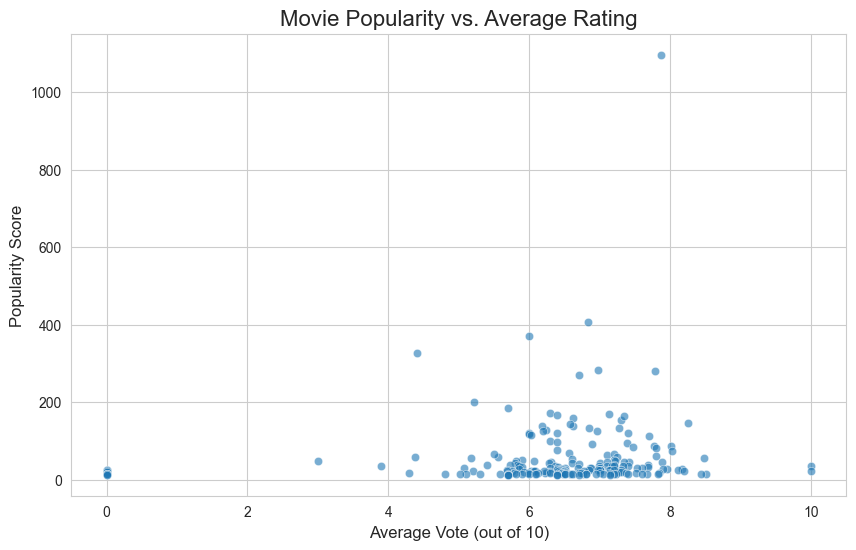

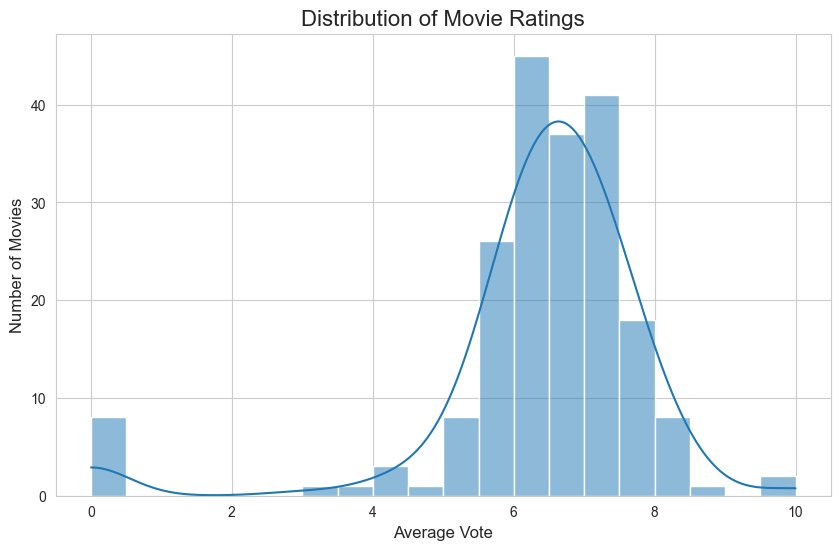

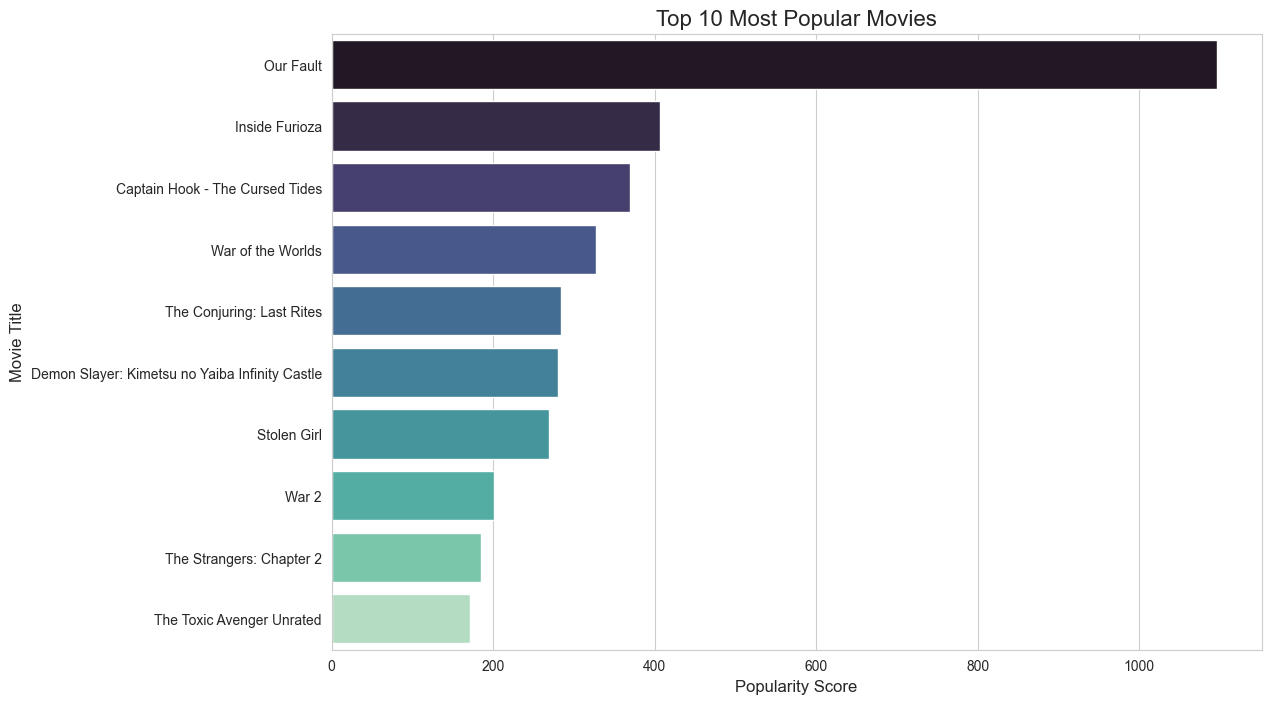

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tmdb_df, x='vote_average', y='popularity', alpha=0.6)
plt.title('Movie Popularity vs. Average Rating', fontsize=16)
plt.xlabel('Average Vote (out of 10)', fontsize=12)
plt.ylabel('Popularity Score', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(tmdb_df['vote_average'], bins=20, kde=True)
plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Average Vote', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.show()

top_10_popular = tmdb_df.sort_values('popularity', ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_popular, x='popularity', y='title', palette='mako', hue='title', legend=False)
plt.title('Top 10 Most Popular Movies', fontsize=16)
plt.xlabel('Popularity Score', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.show()

Web Scrapping

In [39]:
import numpy as np

url = "https://www.boxofficemojo.com/year/2025/"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

table = soup.find("table", class_="mojo-body-table")
rows = table.find_all("tr")[1:]

data = []
for row in rows:
    cols = row.find_all("td")
    if len(cols) < 9:
        continue

    rank = cols[0].text.strip()
    title = cols[1].text.strip()
    gross = cols[5].text.strip()
    theaters = cols[6].text.strip()
    total_gross = cols[7].text.strip()
    release_date = cols[8].text.strip()
    distributor = cols[9].text.strip()

    data.append({
        "Rank": rank,
        "Release": title,
        "Gross": gross,
        "Theaters": theaters,
        "Total Gross": total_gross,
        "Release Date": release_date,
        "Distributor": distributor
    })

df = pd.DataFrame(data)

df['Gross'] = (
    df['Gross']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .replace('-', np.nan)
    .astype(int)
)

df['Theaters'] = (
    df['Theaters']
    .str.replace(',', '', regex=False)
    .replace('-', np.nan)
    .astype(int)
)

df['Total Gross'] = (
    df['Total Gross']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .replace('-', np.nan)
    .astype(int)
)

print(df.to_string(index=False))

Rank                                                        Release     Gross  Theaters  Total Gross Release Date                            Distributor
   1                                              A Minecraft Movie 423949195      4289    423949195        Apr 4                           Warner Bros.
   2                                                  Lilo & Stitch 423778855      4410    423778855       May 23    Walt Disney Studios Motion Pictures
   3                                                       Superman 354184465      4275    354184465       Jul 11                           Warner Bros.
   4                                        Jurassic World: Rebirth 339640400      4324    339640400        Jul 2                     Universal Pictures
   5                                                        Sinners 278578513      3518    278578513       Apr 18                           Warner Bros.
   6                                The Fantastic Four: First Steps 274282985     

## Merging API and Web Scraping Data

In [40]:
tmdb_df['title_normalized'] = tmdb_df['title'].str.strip()
df['title_normalized'] = df['Release'].str.strip()

df_renamed = df.rename(columns={
    'Rank': 'box_office_rank',
    'Release': 'title',
    'Theaters': 'theaters',
    'Total Gross': 'total_gross',
    'Release Date': 'release_date_boxoffice',
    'Distributor': 'distributor'
})

df_renamed = df_renamed[['title', 'box_office_rank', 'theaters', 'total_gross', 'release_date_boxoffice', 'distributor', 'title_normalized']]

merged_df = pd.merge(
    tmdb_df,
    df_renamed,
    left_on='title_normalized',
    right_on='title_normalized',
    how='inner',
    suffixes=('_api', '_boxoffice')
)

merged_df = merged_df.drop(columns=['title_boxoffice', 'title_normalized'])
merged_df = merged_df.rename(columns={'title_api': 'title'})

column_order = [
    'title',
    'box_office_rank',
    'vote_average',
    'popularity',
    'release_date',
    'release_date_boxoffice',
    'total_gross',
    'theaters',
    'distributor'
]

merged_df = merged_df[column_order]

print(f"Successfully merged datasets!")
print(f"TMDb API data: {len(tmdb_df)} movies")
print(f"Box Office Mojo data: {len(df)} movies")
print(f"Merged data: {len(merged_df)} matching movies")

Successfully merged datasets!
TMDb API data: 200 movies
Box Office Mojo data: 200 movies
Merged data: 65 matching movies


In [41]:
print("PREVIEW OF MERGED DATA")
merged_df.head(10)

PREVIEW OF MERGED DATA


,title,box_office_rank,vote_average,popularity,release_date,release_date_boxoffice,total_gross,theaters,distributor
0,The Conjuring: Last Rites,12,6.980,284.0186,2025-09-03,Sep 5,175468847,3802,Warner Bros.
1,War 2,127,5.214,201.2363,2025-08-13,Aug 14,3087065,875,Yash Raj Films USA Inc.
2,The Strangers: Chapter 2,81,5.693,185.1979,2025-09-25,Sep 26,14638366,2690,Lionsgate
3,KPop Demon Hunters,72,8.253,145.3272,2025-06-20,Aug 23,18000000,1700,Netflix
4,Black Phone 2,52,7.349,164.8529,2025-10-15,Oct 17,27332040,3411,Universal Pictures
5,Primitive War,196,6.843,132.5757,2025-08-21,Aug 21,1005222,647,-
6,Mission: Impossible - The Final Reckoning,9,7.274,133.9948,2025-05-17,May 23,197413515,3861,Paramount Pictures International
7,Superman,3,7.400,119.7394,2025-07-09,Jul 11,354184465,4275,Warner Bros.
8,Valiant One,183,6.300,99.0193,2025-01-30,Jan 31,1236630,1275,Briarcliff Entertainment
9,Weapons,13,7.389,94.4426,2025-08-04,Aug 8,151475967,3631,Warner Bros.


## Analysis: Correlation Between User Ratings and Box Office Gross

In [47]:
correlation_rating_gross = merged_df['vote_average'].corr(merged_df['total_gross'])
correlation_popularity_gross = merged_df['popularity'].corr(merged_df['total_gross'])

print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)
print(f"\nCorrelation between Vote Average and Total Gross: {correlation_rating_gross:.4f}")

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
if abs(correlation_rating_gross) < 0.3:
    strength = "weak"
elif abs(correlation_rating_gross) < 0.7:
    strength = "moderate"
else:
    strength = "strong"

direction = "positive" if correlation_rating_gross > 0 else "negative"
print(f"\nThe correlation between user ratings and box office gross is {strength} and {direction}.")


print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
print("\nVote Average:")
print(merged_df['vote_average'].describe())
print("\nTotal Gross (in dollars):")
print(merged_df['total_gross'].describe())

CORRELATION ANALYSIS

Correlation between Vote Average and Total Gross: 0.2589

INTERPRETATION

The correlation between user ratings and box office gross is weak and positive.

DESCRIPTIVE STATISTICS

Vote Average:
count    65.000000
mean      6.725246
std       0.720152
min       4.298000
25%       6.292000
50%       6.800000
75%       7.274000
max       8.253000
Name: vote_average, dtype: float64

Total Gross (in dollars):
count    6.500000e+01
mean     6.196499e+07
std      9.817457e+07
min      1.005222e+06
25%      6.712600e+06
50%      2.332221e+07
75%      5.805133e+07
max      4.239492e+08
Name: total_gross, dtype: float64


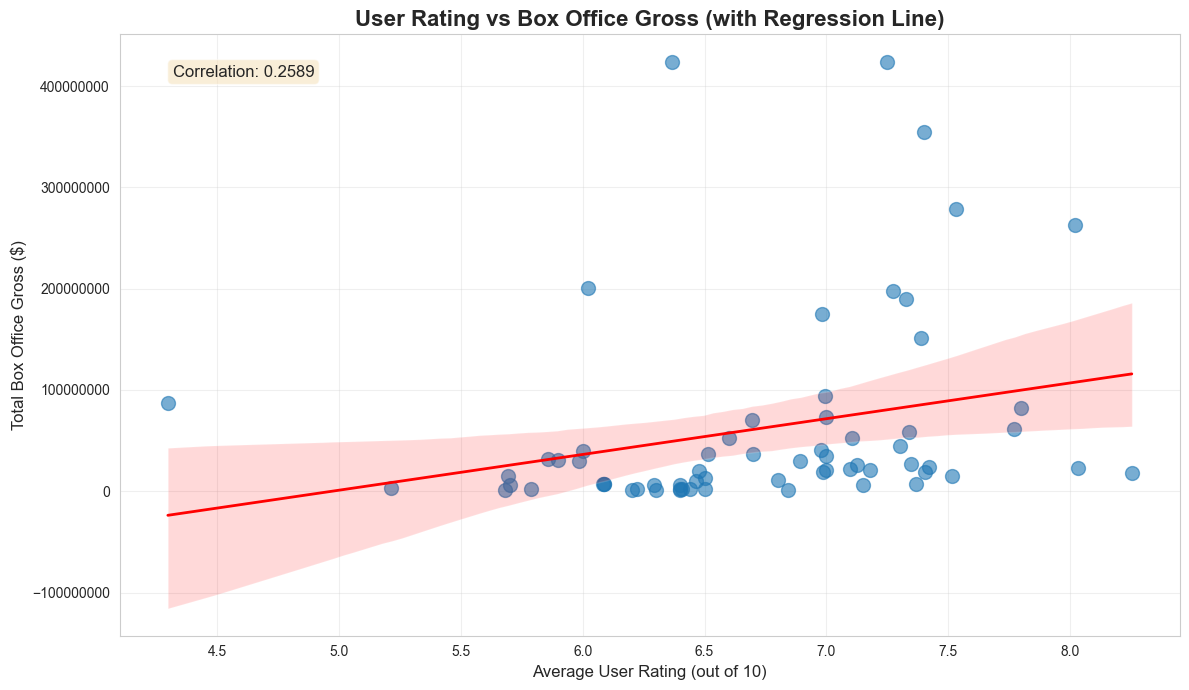

In [43]:
plt.figure(figsize=(12, 7))
sns.regplot(data=merged_df, x='vote_average', y='total_gross', 
            scatter_kws={'alpha':0.6, 's':100}, 
            line_kws={'color':'red', 'linewidth':2})
plt.title('User Rating vs Box Office Gross (with Regression Line)', fontsize=16, fontweight='bold')
plt.xlabel('Average User Rating (out of 10)', fontsize=12)
plt.ylabel('Total Box Office Gross ($)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True, alpha=0.3)

plt.text(0.05, 0.95, f'Correlation: {correlation_rating_gross:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

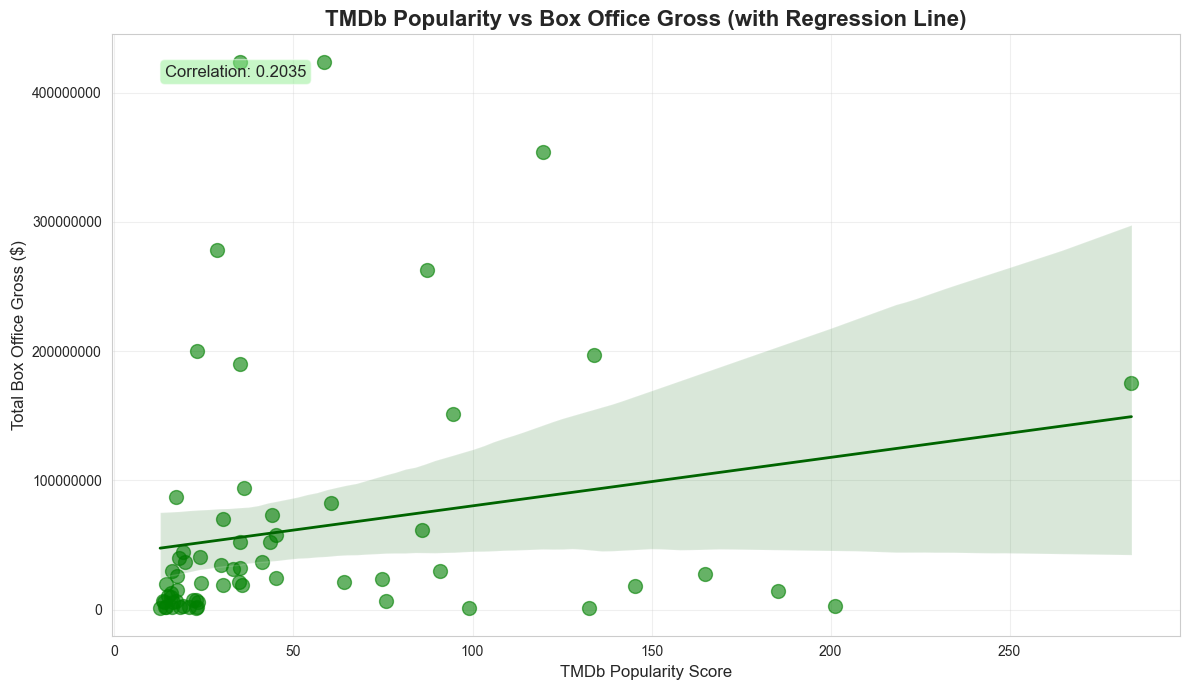

In [44]:
plt.figure(figsize=(12, 7))
sns.regplot(data=merged_df, x='popularity', y='total_gross', 
            scatter_kws={'alpha':0.6, 's':100, 'color':'green'}, 
            line_kws={'color':'darkgreen', 'linewidth':2})
plt.title('TMDb Popularity vs Box Office Gross (with Regression Line)', fontsize=16, fontweight='bold')
plt.xlabel('TMDb Popularity Score', fontsize=12)
plt.ylabel('Total Box Office Gross ($)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True, alpha=0.3)

plt.text(0.05, 0.95, f'Correlation: {correlation_popularity_gross:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
plt.tight_layout()
plt.show()

/var/folders/tl/wvx1w69n1kl_mq7zm1th1fb00000gn/T/ipykernel_61181/192492041.py:22: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/Users/diasjakupov/Desktop/study/data gathering/sis1/data-gathering-sis1/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


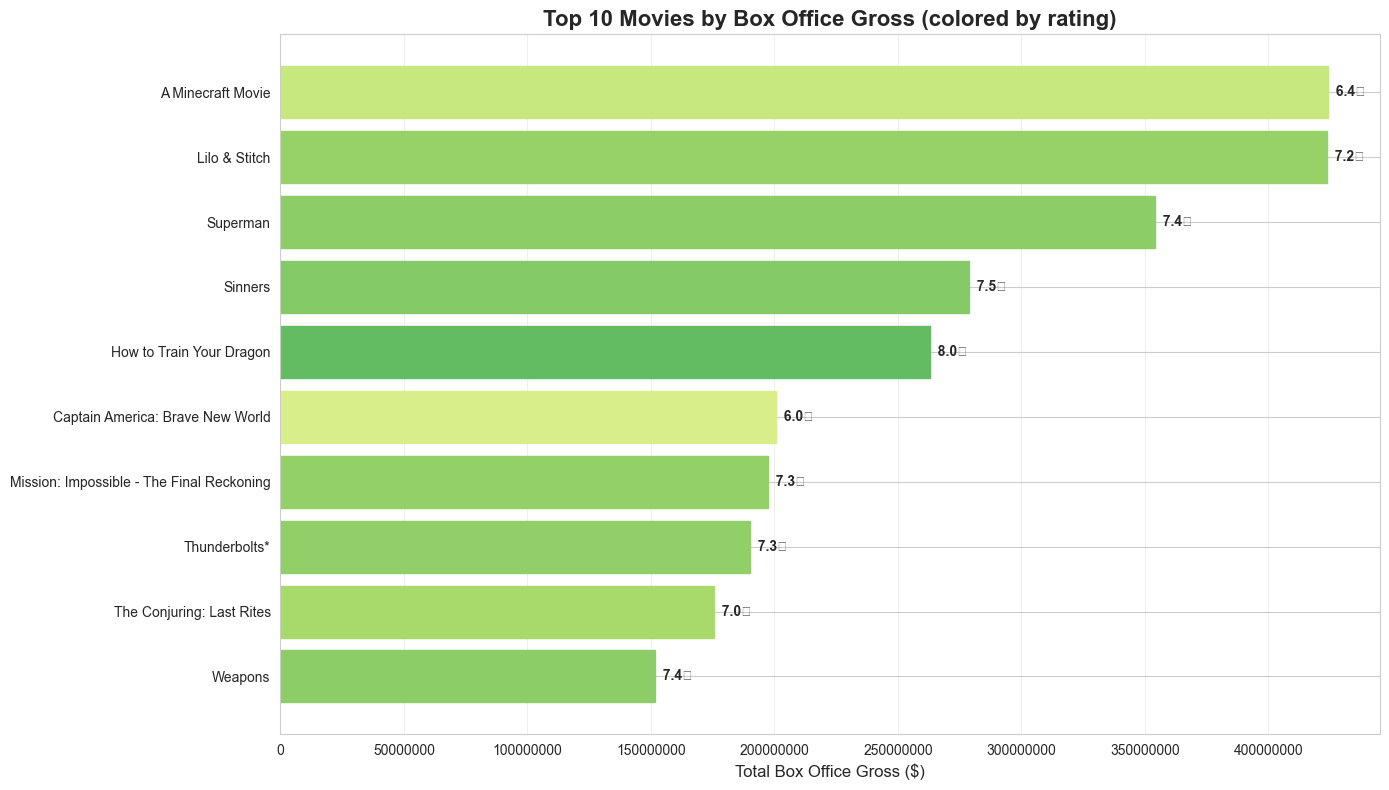

In [ ]:
top_10_gross = merged_df.nlargest(10, 'total_gross')

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.barh(range(len(top_10_gross)), top_10_gross['total_gross'], color='skyblue')

colors = plt.cm.RdYlGn(top_10_gross['vote_average'] / 10)
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_yticks(range(len(top_10_gross)))
ax.set_yticklabels(top_10_gross['title'])
ax.invert_yaxis()
ax.set_xlabel('Total Box Office Gross ($)', fontsize=12)
ax.set_title('Top 10 Movies by Box Office Gross (colored by rating)', fontsize=16, fontweight='bold')
ax.ticklabel_format(style='plain', axis='x')
ax.grid(True, alpha=0.3, axis='x')

for i, (idx, row) in enumerate(top_10_gross.iterrows()):
    ax.text(row['total_gross'], i, f"  {row['vote_average']:.1f}", 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

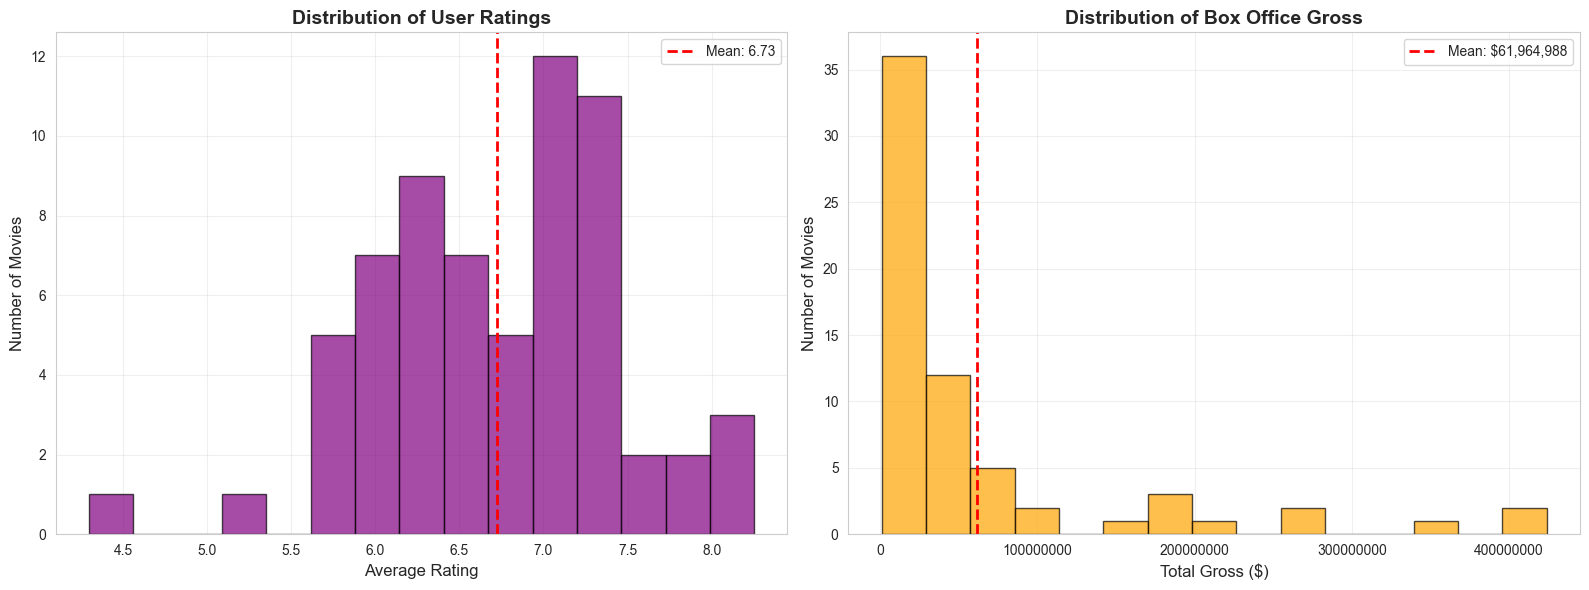

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(merged_df['vote_average'], bins=15, color='purple', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of User Ratings', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Average Rating', fontsize=12)
axes[0].set_ylabel('Number of Movies', fontsize=12)
axes[0].axvline(merged_df['vote_average'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {merged_df["vote_average"].mean():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(merged_df['total_gross'], bins=15, color='orange', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Box Office Gross', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Gross ($)', fontsize=12)
axes[1].set_ylabel('Number of Movies', fontsize=12)
axes[1].ticklabel_format(style='plain', axis='x')
axes[1].axvline(merged_df['total_gross'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: ${merged_df["total_gross"].mean():,.0f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()